### Logistic regression

 - Logistic rergression is a supervised learning algorithm
 - Expresses the probability of one event taking place by having the logarithm of the event's odds be a linear combination of one or more independent variables
 - It outputs probabilities - if p>threshold the data label is 1, if p<threshold data label is 0 - the threshold is commonly 50% but can be adjusted
 - For p=0, the model predicts 1 for all data, if p=1 it predicts 0 for all data
 - Varying the threshold gives a series of true positives and false positive rates, this set is called the receiver operating characteristic curve
 - It is a linear classifier which means it produces a linear decision boundary (a line of any orientation separating two features as opposed to a curved line, which might also be non-contiguous)
 - For a linear classifier to work good you should have a linearly separable dataset
 - The ratio of the coefficients in a two-feature model gives the slope of the line (boundary between class 0 and 1), while the magnitude of the coefficients gives the confidence level
 - A good loss function might be the 0-1 loss function which assigns 0 to the correct classifications and 1 to the incorrect ones and then sums their total. The lower the sum the better the result. But there are issues with trying to minimize this particular loss function, so it is not effectively being used
 - The logistic loss function (used by the logistic regression) and the hinge loss function (used by SVM) are instead more easily minimized
<img src="ml_assets/loss.png" style="width: 300px;"/>

 - Logreg prediction vs probabilities (Sigmoid function)
<img src="ml_assets/logreg.png" style="width: 500px;"/>

 - If you fit a logistic regression model on a classification problem with 3 classes and 100 features, how many coefficients would you have, including intercepts? the answer is 303 (one coef per feature per class and one intercept per class)
 
 - 2 methods for multi-class logistic regression:
     - One-vs-rest: fits multiple logreg models (as many as classes) applying a class vs non-class separation for each data point -> then selects the model with the highest raw output (scikit-learn: logreg.decision_function(X)[0])
     
     - Multinomial or "softmax" (or cross-entropy loss)
     
 - Learn more: https://en.wikipedia.org/wiki/Logistic_regression

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import scale

# Import the necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from scipy.optimize import minimize

In [85]:
cure = load_breast_cancer()
features = pd.DataFrame(scale(cure['data']), columns = cure['feature_names'])
features.shape

(569, 30)

In [86]:
target = pd.DataFrame(cure['target'], columns=['Type']).replace(0,-1)
target.shape

(569, 1)

In [87]:
df = pd.concat([target,features],axis=1)
df.shape

(569, 31)

#### Data split

In [104]:
# Create arrays for the features and the response variable
y = target.values.reshape(-1)
X = features.iloc[:,:10].values

display(y.shape, X.shape)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.35,
                                                    random_state=42)

(569,)

(569, 10)

#### Fit and predict

In [105]:
# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)


#### Performance

In [106]:
# Accuracy score
print('Accuracy', logreg.score(X_test,y_test), "\n")

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy 0.945 

[[ 65   6]
 [  5 124]]
              precision    recall  f1-score   support

          -1       0.93      0.92      0.92        71
           1       0.95      0.96      0.96       129

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



#### ROC

 - A binary classifier that is just randomly making guesses, would be correct approximately 50% of the time, and the resulting ROC curve would be a diagonal line in which the True Positive Rate and False Positive Rate are always equal
 - The Area under this ROC curve would be 0.5

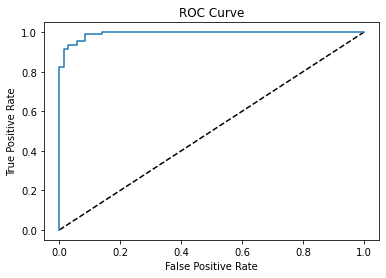

In [107]:
# Import necessary modules
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [108]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.9927939731411726
AUC scores computed using 5-fold cross-validation: [0.97183099 0.98886341 0.99239418 0.98181217 0.99228706]


#### Minimize logistic loss function

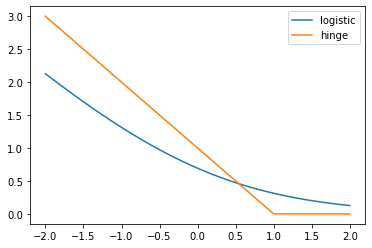

In [109]:
# Mathematical functions for logistic and hinge losses
def log_loss(raw_model_output):
    return np.log(1+np.exp(-raw_model_output))

def hinge_loss(raw_model_output):
    return np.maximum(0,1-raw_model_output)

# Create a grid of values and plot
grid = np.linspace(-2,2,1000)
plt.plot(grid, log_loss(grid), label='logistic')
plt.plot(grid, hinge_loss(grid), label='hinge')
plt.legend()
plt.show()

In [110]:
# The logistic loss, summed over training examples
def my_loss(w):
    s = 0
    for i in range(y.size):
        raw_model_output = w@X[i]
        s = s + log_loss(raw_model_output * y[i])
    return s

# Returns the w that makes my_loss(w) smallest
w_fit = minimize(my_loss, X[0]).x
print(w_fit)

# Compare with scikit-learn's LogisticRegression
lr = LogisticRegression( fit_intercept=False, C=100000000 ).fit(X,y)
print(lr.coef_)

[ 1.03589352 -1.65378358  4.08334119 -9.40922278 -1.06786256  0.07891865
 -0.85110075 -2.44103586 -0.4528559   0.43353408]
[[ 1.03607782 -1.65380466  4.08303975 -9.40914754 -1.06787403  0.07896359
  -0.85099701 -2.44109033 -0.45288783  0.43348886]]


#### Regularization of logistic regression

 - Regularization penalizes larger coefficients
 - C = the inverse of the regularization strength
 - Larger (smaller) C = less (more) regularization
 - More regularization will make the training accuracy to go down (as the magnitude of some coefficients is diminished or goes to 0), but for the same reason it makes the test set accuracy to increase (so if using some coefficient was leading to over-fitting then regularization will lead to less over-fitting which improves performance on the test set)
 - Too much regularization (small C) doesn't work well - due to underfitting - and too little regularization (large C) doesn't work well either - due to overfitting
 - For linear regressions, we have Lasso (L1 regularization) and Ridge (L2 regularization), for logistic regressions we keep the names lamda 1 and 2
 - Smaller values of C lead to less confident predictions. That's because smaller C means more regularization, which in turn means smaller coefficients, which means raw model outputs closer to zero and, thus, probabilities closer to 0.5 after the raw model output is squashed through the sigmoid function

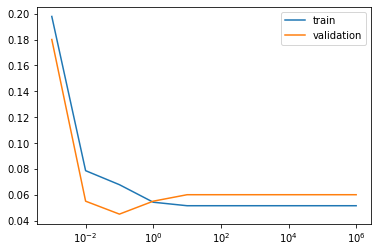

In [117]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()

# Loop over values of C_value
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000000]

for C_value in C_values:
    # Create LogisticRegression object and fit
    lr = LogisticRegression(C=C_value)
    lr.fit(X_train, y_train)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - lr.score(X_train, y_train) )
    valid_errs.append( 1.0 - lr.score(X_test, y_test) )
    
# Plot results
plt.semilogx(C_values, train_errs, C_values, valid_errs)
plt.legend(("train", "validation"))
plt.show()

#### Feature selection

In [124]:
# Create arrays for the features and the response variable
y = target.values.reshape(-1)
X = features.values

display(y.shape, X.shape)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.35,
                                                    random_state=42)

(569,)

(569, 30)

Note - The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, or no regularization. The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the ‘saga’ solver.

In [130]:
# Specify L1 regularization
lr = LogisticRegression(penalty='l1',solver='liblinear')

In [131]:
# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [132]:
# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 0.1}
Total number of features: 30
Number of selected features: 8


#### Multiple classes

In [134]:
from sklearn.datasets import load_wine

wines = load_wine()

features = pd.DataFrame(scale(wines['data']), columns = wines['feature_names'])
target = pd.DataFrame(wines['target'], columns=['Type'])


# Create arrays for the features and the response variable
y = target.values.reshape(-1)
X = features.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



In [135]:
# Fit one-vs-rest logistic regression classifier
lr_ovr = LogisticRegression()
lr_ovr.fit(X_train, y_train)

print("OVR training accuracy:", lr_ovr.score(X_train, y_train))
print("OVR test accuracy    :", lr_ovr.score(X_test, y_test))

# Fit softmax classifier
lr_mn = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr_mn.fit(X_train, y_train)

print("Softmax training accuracy:", lr_mn.score(X_train, y_train))
print("Softmax test accuracy    :", lr_mn.score(X_test, y_test))

OVR training accuracy: 1.0
OVR test accuracy    : 0.9814814814814815
Softmax training accuracy: 1.0
Softmax test accuracy    : 0.9814814814814815
